# <center>Assignment 2 LSTM - Fixed Window Size

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Basic Time Series Setting
import statsmodels.api as smapi
import statsmodels.tsa.api as smt

In [3]:
# RNN Package Setting
import time
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras import optimizers

Using Theano backend.


In [4]:
data=pd.read_csv('internet_retail_sales.csv',parse_dates=[0], index_col=0)
sales=data.values

In [5]:
np.random.seed(1)

## Data Preparation

### Seasonality Adjust

### Standardisation

In [6]:
# Standardisation
scaler = StandardScaler()
sales_scaled=scaler.fit_transform(sales)

### Fixed Data Window

In [7]:
# Creating Training and Test feature
time_window=12

Xall, yall=[],[]

for i in range(time_window, len(sales_scaled)):
    Xall.append(sales_scaled[i-time_window:i,0])
    yall.append(sales_scaled[i,0])

Xall=np.array(Xall)
yall=np.array(yall)

### Train Test Split

In [8]:
# Train Test Split
test_size=12
Xtrain, Xtest=Xall[0:-test_size], Xall[-test_size:]
ytrain, ytest=yall[0:-test_size], yall[-test_size:]

In [9]:
y_train_raw=sales[0:-test_size]
y_test_raw=sales[-test_size:]

### Reshape Data Window into 3D

In [10]:
Xtrain, Xtest=Xtrain.reshape(Xtrain.shape[0], time_window, 1), Xtest.reshape(Xtest.shape[0], time_window, 1)
print(Xtrain.shape)
print(Xtest.shape)

(113, 12, 1)
(12, 12, 1)


## RNN-Fixed Window Size Model Fitting

In [11]:
# build LSTM Model
adam=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
neurons=1
model=Sequential()
model.add(LSTM(neurons,input_shape = (time_window,1), batch_size=1,stateful=True))
# model.add(Dropout(0.2))
model.add(Dense(1))

# compile model for use
start=time.time()
model.compile(loss="mse", optimizer="adam")
print("Compilation Time : ", time.time() - start)

Compilation Time :  0.006981372833251953


In [12]:
max_len = 12
from keras.callbacks import Callback  
class ResetStatesCallback(Callback):
    def __init__(self):
        self.counter = 0

    def on_batch_begin(self, batch, logs={}):
        if self.counter % max_len == 0:
            self.model.reset_states()
        self.counter += 1

In [13]:
# Training Model
epochs=1
history=model.fit(Xtrain,ytrain,batch_size=1,nb_epoch=epochs,validation_split=0.1,shuffle=False)
# callbacks=[ResetStatesCallback()],
# 
# model.reset_states()

Train on 101 samples, validate on 12 samples
Epoch 1/1
101/101 [==============================] - 0s 2ms/step - loss: 0.6264 - val_loss: 2.6431


In [14]:
# Predict
train_predict = model.predict(Xtrain,batch_size=1)
test_predict = model.predict(Xtest,batch_size=1)

# Inverse Prediction
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

## Training Score

In [15]:
epochs_summary=[]
neurons_summary=[]
rmse_summary=[]

In [16]:
rmse=math.sqrt(mean_squared_error(y_test_raw,test_predict))

In [17]:
epochs_summary.append(epochs)
neurons_summary.append(neurons)
rmse_summary.append(rmse)

print(epochs_summary)
print(neurons_summary)
print(rmse_summary)

[1]
[1]
[672.8875604776836]


## Diagnostic Plot

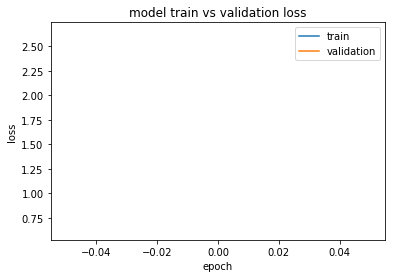

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [19]:
history.history

{'loss': [0.6263677532883773], 'val_loss': [2.6431317230065665]}